##ThinkDSP

This notebook contains code examples from Chapter 9: Signals and Systems

Copyright 2015 Allen Downey

License: [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/)

In [1]:
from __future__ import print_function, division

import thinkdsp
import thinkplot
import math
import numpy as np
import pandas
import scipy.signal

PI2 = 2 * math.pi

%precision 3
%matplotlib inline

We'll start by exploring the price of BitCoin, which resembles red noise:

In [2]:
df = pandas.read_csv('coindesk-bpi-USD-close.csv', nrows=1625, parse_dates=[0])
ys = df.Close.values

Here's what the time series looks like:

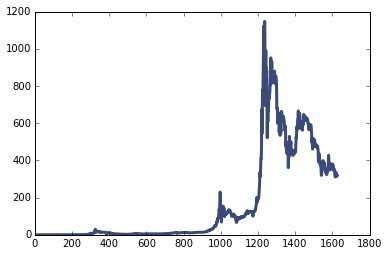

In [3]:
wave = thinkdsp.Wave(ys, framerate=1)
wave.plot()

And here's the spectrum on a log-log scale.

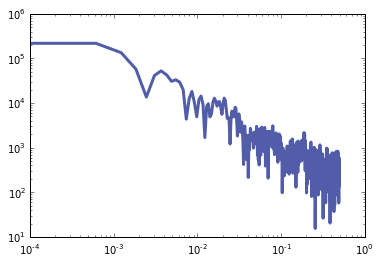

In [4]:
spectrum = wave.make_spectrum()
spectrum.plot()
thinkplot.config(xscale='log', yscale='log', legend=False)

The slope is -1.8, which is similar to red noise (which should have a slope of -2).

In [5]:
spectrum.estimate_slope()

(-1.805, 9.786, -0.811, 0.000, 0.046)

We can use `np.diff` to compute the difference between successive elements, which is the daily change.

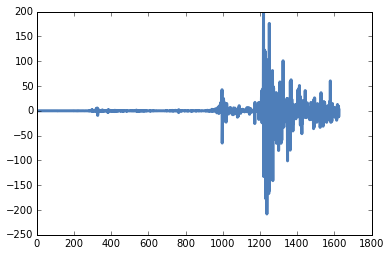

In [6]:
diff = np.diff(ys)
wave2 = thinkdsp.Wave(diff, framerate=1)
wave2.plot()

And here's the spectrum of the daily changes:

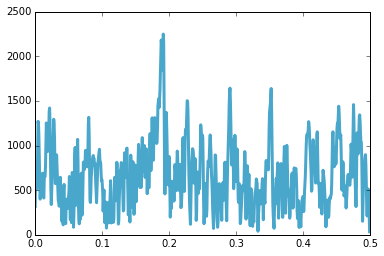

In [7]:
spectrum2 = wave2.make_spectrum()
spectrum2.plot()

And here's the spectrum on a log-log scale.

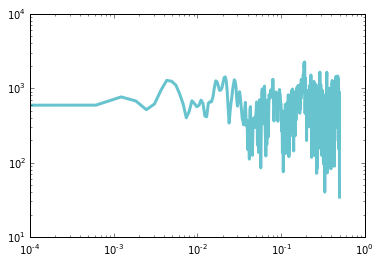

In [8]:
spectrum2.plot()
thinkplot.config(xscale='log', yscale='log', legend=False)

The estimated slope is close to zero, which is consistent with white noise.

In [9]:
spectrum2.estimate_slope()

(-0.023, 12.635, -0.018, 0.614, 0.045)

Now let's compare the spectrum of closing price with the spectrum of daily changes; that is, the ratio of the spectrums before and after applying 'np.diff':

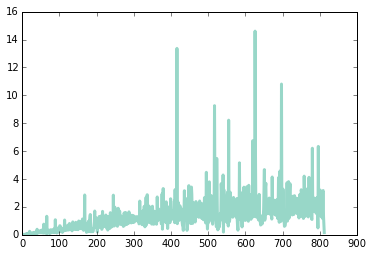

In [10]:
amps = spectrum.amps
amps2 = spectrum2.amps

n = min(len(amps), len(amps2))
ratio = amps2[:n] / amps[:n]

thinkplot.plot(ratio)

We can think the diff operation as convolution with a difference window:

In [11]:
window = np.array([1.0, -1.0])

And we can use `scipy.signal.convolve` to compute it:

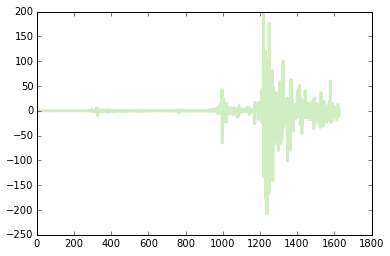

In [12]:
ys = scipy.signal.convolve(wave.ys, window, mode='valid')
diff = thinkdsp.Wave(ys, framerate=1)
diff.plot()

Or you can compute the same thing by computing the difference filter, which is the DFT of the difference window, and they multiplying in the frequency domain.

In [13]:
def zero_pad(array, n):
    res = np.zeros(n)
    res[:len(array)] = array
    return res

Here are two windows that approximate the first derivative:

In [14]:
window = np.array([1.0, -1.0])
window2 = np.array([-1, 4, -3]) / 2.0

padded = zero_pad(window, len(wave))

And here's what the corresponding filter looks like:

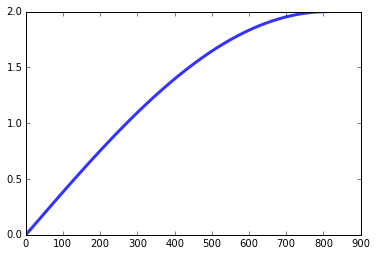

In [15]:
fft_window = np.fft.rfft(padded)
thinkplot.plot(abs(fft_window))

Now here's the filter again, superimposed on the ratios we computed earlier:

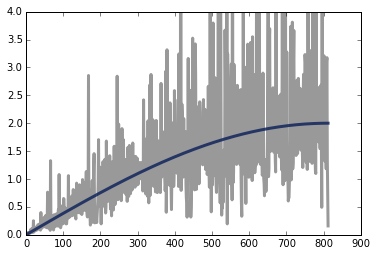

In [16]:
thinkplot.plot(ratio, color='gray')
thinkplot.plot(abs(fft_window))
thinkplot.config(ylim=[0, 4])

The difference filter has this shape because it is an approximation of differentiation, and the filter for differentiation is proportional to $f$.  Specifically, each complex component is multiplied by $2 \pi i f$.  So we can compute a numerical derivative by applying this filter in the frequency domain:

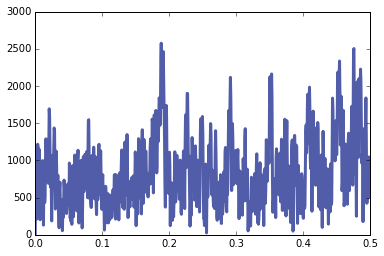

In [17]:
spectrum3 = wave.make_spectrum()
i = complex(0, 1)
filtr = PI2 * i * spectrum3.fs
spectrum3.hs *= filtr
spectrum3.plot()

The results are similar, with some differences due to (1) the difference window is only a coarse approximation of the derivative, especially at higher frequencies, and (2) the spectral derivative is based on the assumption that the signal is periodic, so the behavior at the beginning and end is different.

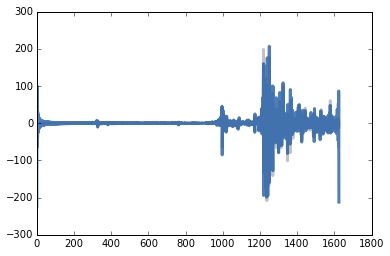

In [18]:
wave3 = spectrum3.make_wave()
wave2.plot(color='0.7')
wave3.plot()

Here's the difference between the derivative filter and the difference filter:

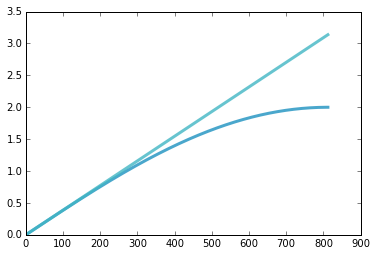

In [19]:
amps = spectrum.amps
amps3 = spectrum3.amps
ratio3 = amps3 / amps
thinkplot.plot(abs(fft_window))
thinkplot.plot(ratio3)

The next topic is the use of impulse response for system characterization.  We start with a recording of a gunshot:

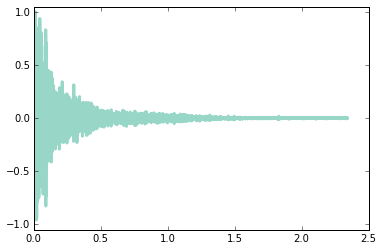

In [20]:
response = thinkdsp.read_wave('180961__kleeb__gunshots.wav')
response = response.segment(start=0.26, duration=5.0)
response.normalize()
response.plot()
thinkplot.config(ylim=[-1.05, 1.05])

Here's what it sounds like:

In [21]:
response.make_audio()

The recording is the impulse response of the system (the room and recording equipment).   The DFT of the impulse response is the transfer function:

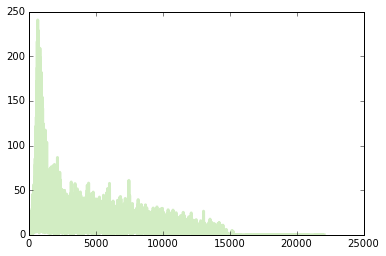

In [22]:
transfer = response.make_spectrum()
transfer.plot()

Here's the transfer function on a log-log scale:

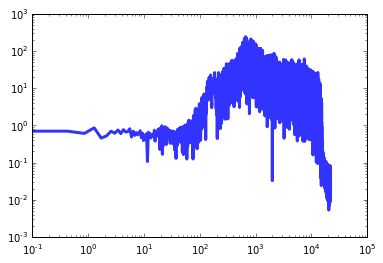

In [23]:
transfer.plot()
thinkplot.config(xscale='log', yscale='log')

Now we can simulate what a recording would sound like if it were played in the same room and recorded in the same way.  Here's the violin recording we have used before:

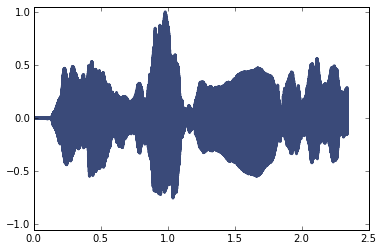

In [24]:
violin = thinkdsp.read_wave('92002__jcveliz__violin-origional.wav')
violin.ys = violin.ys[:len(response)]
violin.normalize()
violin.plot()
thinkplot.config(ylim=[-1.05, 1.05])

Here's what it sounds like before transformation:

In [25]:
violin.make_audio()

Now we compute the DFT of the violin recording.

In [26]:
spectrum = violin.make_spectrum()

I trimmed the violin recording to the same length as the impulse response:

In [27]:
len(spectrum.hs), len(transfer.hs)

(51589, 51589)

We we can multiply in the frequency domain and the transform back to the time domain.

In [28]:
output = (spectrum * transfer).make_wave()
output.normalize()

Here'a  comparison of the original and transformed recordings:

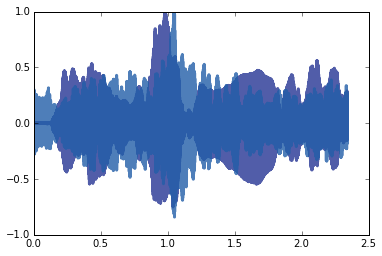

In [29]:
violin.plot()
output.plot()

And here's what it sounds like:

In [30]:
output.make_audio()

To understand how that worked, you can think about the input signal as a series of impulses, and the output as the sume of shifted, scaled versions of the impulse response.

In [31]:
def shifted_scaled(wave, shift, factor):
    res = wave.copy()
    res.shift(shift)
    res.scale(factor)
    return res

Here's what it would sound like if we fired a big gun followed by a small gun:

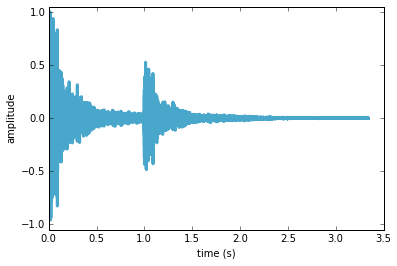

In [32]:
dt = 1
shift = dt * response.framerate
factor = 0.5

response2 = response + shifted_scaled(response, shift, factor)
response2.plot()
thinkplot.config(xlabel='time (s)', ylabel='amplitude', ylim=[-1.05, 1.05])

Two gunshots:

In [33]:
response2.make_audio()

Here's what it sounds like if we fire 100 guns at a rate of 441 gunshots per second:

In [34]:
total = 0
for j in range(100):
    total += shifted_scaled(response, j*100, 1.0)
total.normalize()

In [35]:
total.make_audio()

The result has a fundamental frequency at 441, with additional harmonics.

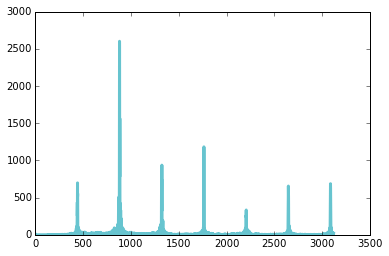

In [36]:
total.make_spectrum().plot(high=8000)

Now let's do the same thing with a sawtooth signal:

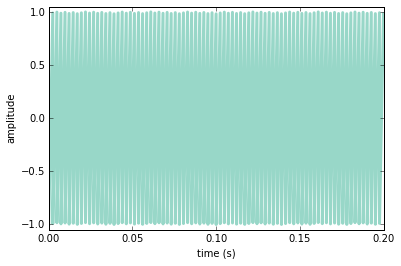

In [37]:
sawtooth = thinkdsp.SawtoothSignal(freq=410).make_wave(duration=0.2, framerate=response.framerate)
sawtooth.plot()
thinkplot.config(xlabel='time (s)', ylabel='amplitude', ylim=[-1.05, 1.05])

Here's what it sounds like:

In [38]:
sawtooth.make_audio()

And here's what we get if we use the sawtooth to generate shifted, scaled versions of the impulse response:

In [39]:
total = 0
for j, y in enumerate(sawtooth.ys):
    total += shifted_scaled(response, j, y)
total.normalize()

The result is a simulation of what the sawtooth signal would sound like if it was recorded in the room where the gunshot was recorded:

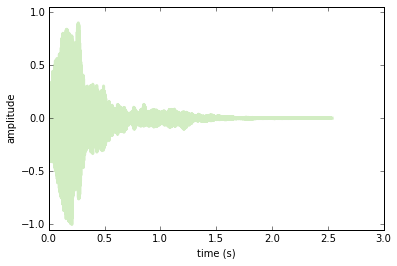

In [40]:
total.plot()
thinkplot.config(xlabel='time (s)', ylabel='amplitude', ylim=[-1.05, 1.05])

And here's what it sounds like:

In [41]:
total.make_audio()

To me it sounds a bit like a car horn in a garage.

And here's the spectrum:

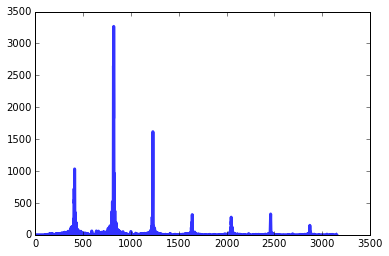

In [42]:
total.make_spectrum().plot(high=8000)

Here's a comparison before and after convolution:

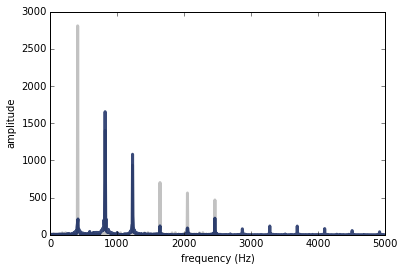

In [43]:
sawtooth.make_spectrum().plot(high=500, color='0.7')

segment = total.segment(duration=0.2)
segment.make_spectrum().plot(high=1000)
thinkplot.config(xlabel='frequency (Hz)', ylabel='amplitude')

Now that we recognize this operation as convolution, we can compute it by multiplying the signals (which performs convolution):

In [44]:
convolved = sawtooth.convolve(response)
convolved.normalize()
convolved.make_audio()

And we can do the same thing with the violin recording:

In [45]:
convolved2 = violin.convolve(response)
convolved2.normalize()
convolved2.make_audio()

To understand why the impulse response is sufficient to characterize a system, it is informative to look at the DFT of an impulse:

In [46]:
impulse = np.zeros(8)
impulse[0] = 1
print(impulse)

[ 1.  0.  0.  0.  0.  0.  0.  0.]


The DFT of an impulse is all ones, which means that the impulse contains equal energy at all frequencies.  So testing a system with an impulse is like testing it will all frequency components at the same time:

In [47]:
spectrum = np.fft.fft(impulse)
print(spectrum)

[ 1.+0.j  1.+0.j  1.+0.j  1.+0.j  1.+0.j  1.+0.j  1.+0.j  1.+0.j]


You might notice something about the impulse and its DFT:

In [48]:
np.sum(np.absolute(impulse)**2)

1.000

In [49]:
np.sum(np.absolute(spectrum)**2)

8.000

In general, the total magnitue of DFT(y) is N times the total magnitude of y.

Finally, let's look at a mini example of system characterization.  Suppose you have a system that smooths the signal by taking a moving average of adjacent elements:

In [50]:
window = np.array([0.5, 0.5, 0, 0, 0, 0, 0, 0,])

For this moving average window, we can compute the transfer function:

In [51]:
filtr = scipy.fftpack.fft(window)
filtr

array([ 1.000+0.j   ,  0.854-0.354j,  0.500-0.5j  ,  0.146-0.354j,
        0.000+0.j   ,  0.146+0.354j,  0.500+0.5j  ,  0.854+0.354j])

Here are the magnitudes:

In [52]:
np.absolute(filtr)

array([ 1.   ,  0.924,  0.707,  0.383,  0.   ,  0.383,  0.707,  0.924])

To visualize the transfer function, I'll roll it so that frequency 0 is in the middle.  The DFT of a smoothing window is approximately Gaussian:

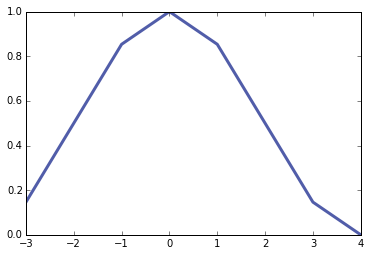

In [53]:
rolled = np.roll(filtr, 3)
thinkplot.plot([-3, -2, -1, 0, 1, 2, 3, 4], rolled.real)

If you multiply the transfer function by the spectrum of an impulse (which is all ones), the result is the filter:

In [54]:
product = spectrum * filtr
print(product)

[ 1.000+0.j     0.854-0.354j  0.500-0.5j    0.146-0.354j  0.000+0.j
  0.146+0.354j  0.500+0.5j    0.854+0.354j]


Now if you transform back to the time domain, you have the impulse response, which looks a lot like the window:

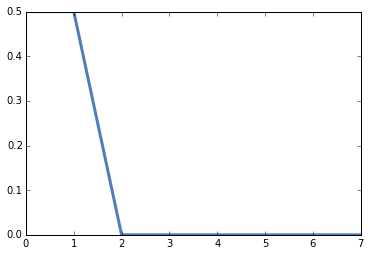

In [55]:
filtered = scipy.fftpack.ifft(product)
thinkplot.plot(filtered.real)

In [56]:
print(filtered.real)

[  5.000e-01   5.000e-01   0.000e+00   0.000e+00   0.000e+00   2.776e-17
   0.000e+00   0.000e+00]


This example is meant to demonstrate why a recording of an impulse response is sufficient to characterize a system: because it is the IDFT of the transfer function.